## Choosing flowers for a garden - example data manipulation & exploratory analysis


Goal: Identify candidate flowers for garden based on the garden's location (including geographic hardiness zone and local sunshine exposure), season of desired bloom, as well as the flower's maintenance considerations and water requirements.  

Inputs: Dataset - "A to Z Flowers - Features & Images" [https://www.kaggle.com/kkhandekar/a-to-z-flowers-features-images]

Notebook sections:
1. Setup libraries, directories, inputs (csv dataset & images)
2. Relevant field exploration & cleaning - missing values, unique values, etc
3. Limitations
4. Test cases - show flower candidates based on user criteria

Potential future improvements: Further refine flower recommendations based on desired color, soil requirements, and height. These fields have losts of text and additional parsing will be needed to categorize or isolate min/max/average heights, specific colors, and soil characteristics. 

#### 1. Setup 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

from IPython.display import Image

In [2]:
## data directory, image directory, csv filename
directory = './flowers_dataset/'
jpg_directory = directory + 'FlowersJPG/content/Flowers/'
data_file = 'FlowerDatabase.csv'

In [3]:
## pull in data
df = pd.read_csv(directory + data_file)

## check out the first row
print(df.iloc[0])

Name                                              Achillea (Yarrow)
Desc              <p>Achillea, commonly known as Yarrow, is a ge...
PlantType                                                Perennials
Color             Yarrow comes in a wide range of colors includi...
HardinessZones                                                  3-9
BloomsIn                                             Spring, Summer
Height            This plant usually grows between 30 and 90 cm ...
SoilNeeds         Achillea will grow best in well drained soil, ...
SunNeeds                                                   Full sun
WaterNeeds                                                      low
Maintenance                                                     low
RelatedFlowers    ['ageratum', 'asters', 'bellis', 'cosmos', 'da...
Name: 0, dtype: object


In [4]:
## create list of included images, show some examples
flower_images = os.listdir(jpg_directory)
flower_images[0:10]

['Veronicastrum.jpg',
 'Plumeria.jpg',
 'Lobelia.jpg',
 'Hosta.jpg',
 'Ursinia.jpg',
 'Fuchsia.jpg',
 'Crocus.jpg',
 'Galanthus.jpg',
 'Echeveria.jpg',
 'Hyssopus.jpg']

In [5]:
## create alphabetical list of flowers from list of flower images
flowers = [x.lower().split('.')[0] for x in flower_images]
flowers.sort()
flowers[0:3],flowers[-3:]

(['achillea', 'aconitum', 'agapanthus'],
 ['zephyranthes', 'zinnia', 'zygopetalum'])

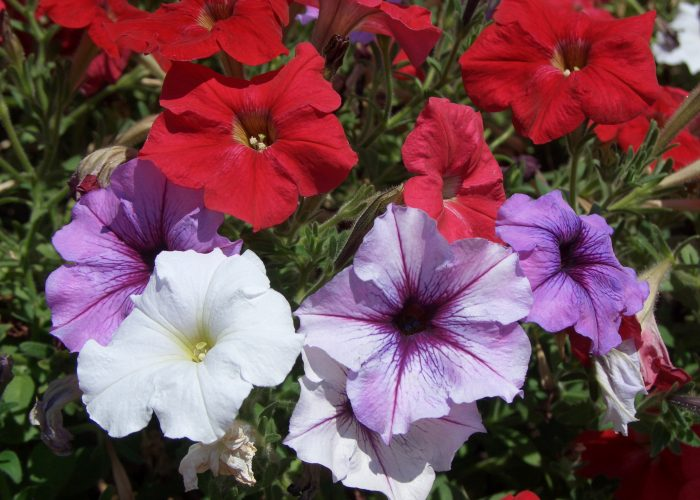

In [6]:
## show random example image
Image(jpg_directory+flower_images[random.randint(0,len(flowers))])

#### 2. Fields

In [7]:
## size of dataset
print(df.shape[0])

## null values
df.isnull().sum()

223


Name              0
Desc              0
PlantType         1
Color             0
HardinessZones    0
BloomsIn          0
Height            0
SoilNeeds         0
SunNeeds          0
WaterNeeds        0
Maintenance       0
RelatedFlowers    0
dtype: int64

In [8]:
## unique values
df.nunique()

Name              223
Desc              223
PlantType          32
Color             221
HardinessZones     32
BloomsIn           12
Height            221
SoilNeeds         223
SunNeeds            5
WaterNeeds          2
Maintenance         3
RelatedFlowers      1
dtype: int64

In [9]:
## names field to be cleaned up as new field: (1) remove aliases in parentheses, leading trailing space 
## & (2) make lowercase
df['name_cleaned'] = [x.split('(')[0].strip(' ').lower() for x in df['Name']]
df['name_cleaned'].head()

## check if there is an image file for each name
print('there is an image for each name in dataset: ',
      sum([1 for x in df['name_cleaned'] if x in flowers]) == df.shape[0])

there is an image for each name in dataset:  True


In [10]:
## as RelatedFlowers only has one value and no nulls, it's not useful. drop RelatedFlowers
df.drop('RelatedFlowers',axis=1,inplace=True)

PlantType


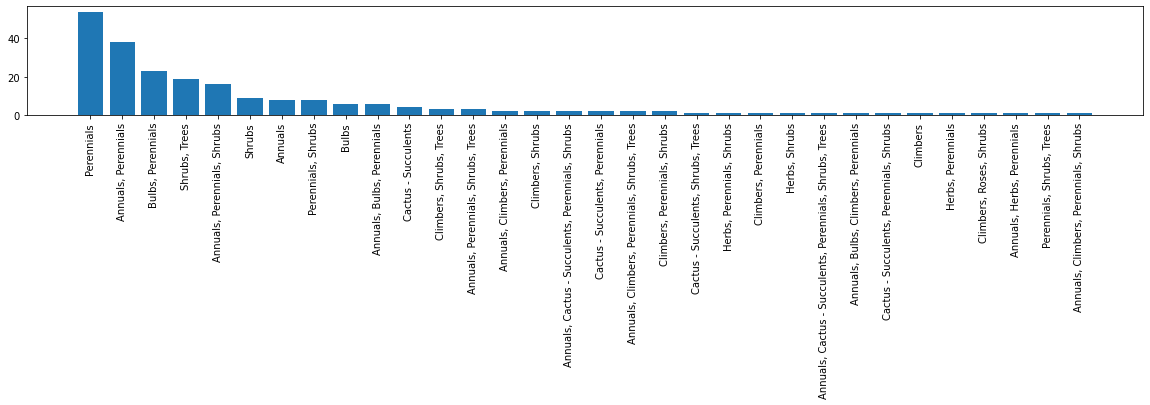

HardinessZones


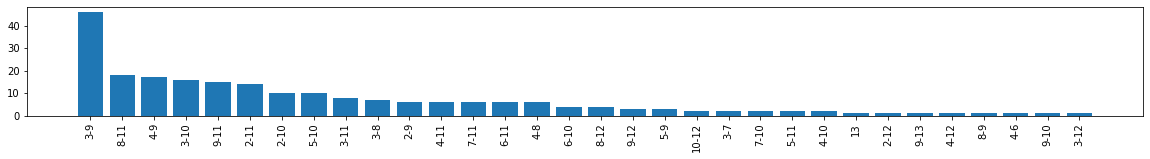

BloomsIn


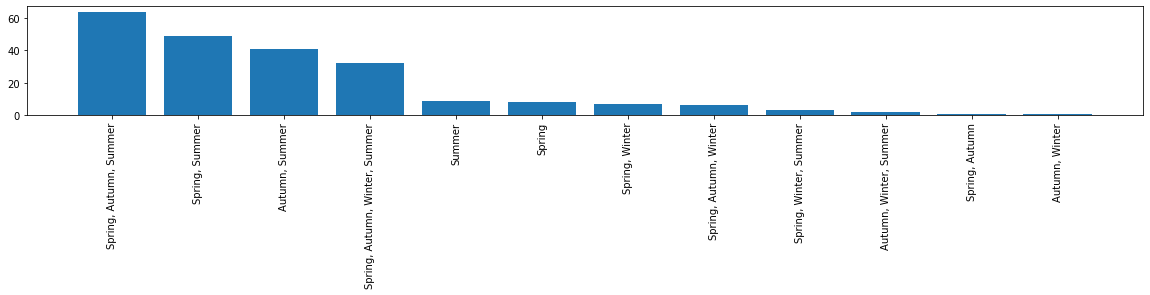

SunNeeds


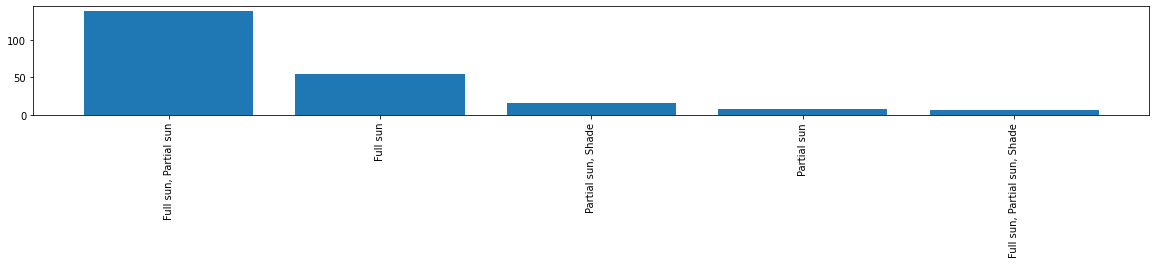

WaterNeeds


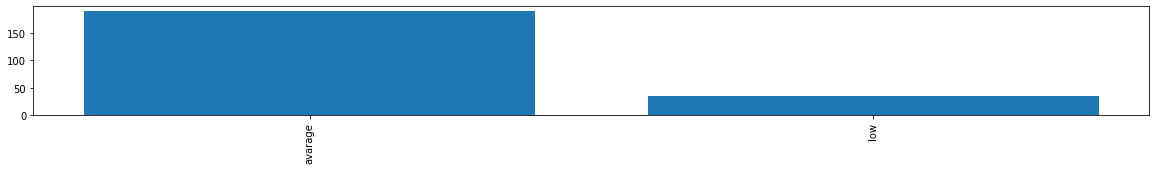

Maintenance


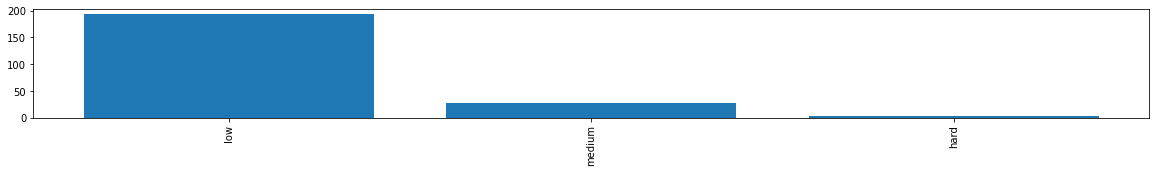

In [11]:
## create list of fields where it would be helpful to see a frequency breakdown of values
fields_for_frequency_graphs =['PlantType','HardinessZones','BloomsIn','SunNeeds','WaterNeeds','Maintenance']

## show distribution of values for each of these identified fields
for field_for_frequency_graph in fields_for_frequency_graphs:
    print(field_for_frequency_graph)
    plt.figure(figsize=(20,2))
    plt.xticks(rotation=90)
    plt.bar(df[field_for_frequency_graph].value_counts().reset_index()['index'],
            df[field_for_frequency_graph].value_counts().reset_index()[field_for_frequency_graph])
    plt.show()
    plt.close()

###### 2a. Field: PlantType

In [12]:
## plantType does not help address the stated goal given that all included plants are also flowers
## drop PlantType field for now
df.drop('PlantType',axis=1,inplace=True)

##### 2b. Field: HardinessZones

In [13]:
## no nulls in hardiness zones, it appears to be a range in most cases, otherwise a single value for zone.
## create two fields for hardiness min and max. Min and Max will be the same for the cases with one listed zone
df['hardiness_min'] = [int(x.split('-')[0].strip(' ')) if '-' in x else int(x) for x in df['HardinessZones']]
df['hardiness_max'] = [int(x.split('-')[1].strip(' ')) if '-' in x else int(x) for x in df['HardinessZones']]

In [14]:
## look at overall range of zones
df['hardiness_min'].min(), df['hardiness_max'].max()

(2, 13)

In [15]:
## drop HardinessZones fields
df.drop('HardinessZones',axis=1,inplace=True)

(Text(0.5, 0, 'zone'), Text(0, 0.5, 'flowers'))

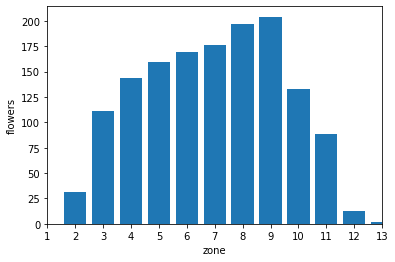

In [16]:
## evaluate the number of flowers that can grow in each hardiness zone (1-13)
hardiness_zone_df = pd.DataFrame()
hardiness_zones = list(range(1,14))
for hardiness_zone in hardiness_zones:
    flowers_grow_in_zone = df.loc[df.hardiness_max >= hardiness_zone].loc[df.hardiness_min <= hardiness_zone]
    hardiness_zone_df = hardiness_zone_df.append({'zone':hardiness_zone,
                                                 'flowers':flowers_grow_in_zone.shape[0]},
                                                 ignore_index=True)
    
plt.bar(hardiness_zone_df['zone'],hardiness_zone_df['flowers'])
plt.xlim(1,13), plt.xticks(hardiness_zones)
plt.xlabel('zone'), plt.ylabel('flowers') ## makes sense that there are 0 for zone 1... very cold!

##### 2c. Field: BloomsIn

In [17]:
## some flowers bloom in multiple seasons. show all seasons included in dataset
seasons = list(set([x.lower().strip(' ') for x in ','.join(df['BloomsIn']).split(',')]))
seasons

['autumn', 'winter', 'summer', 'spring']

In [18]:
## create flag field for each season
for season in seasons:
    df['blooms - {}'.format(season)] = [1 if season in x.lower() else 0 for x in df['BloomsIn']]

In [19]:
## show how many flowers bloom in each season
df[[x for x in df.columns if 'blooms' in x]].sum() ## seems reasonable, much fewer flowers bloom in winter

blooms - autumn    147
blooms - winter     51
blooms - summer    200
blooms - spring    170
dtype: int64

In [20]:
## drop BloomsIn field
df.drop('BloomsIn',axis=1,inplace=True)

##### 2d. Field: SunNeeds

In [21]:
## some flowers can live w/ varying sun amounts
sun_needs = list(set([x.lower().strip(' ') for x in ','.join(df['SunNeeds']).split(',')]))
sun_needs

['full sun', 'partial sun', 'shade']

In [22]:
## create flag field for sun amt, simplify to shade/partial/full instead of "full sun", "partial sun", "shade"
for sun_need in sun_needs:
    sun_column_name = 'sun - {}'.format(sun_need.replace(' sun',''))
    df[sun_column_name] = [1 if sun_need in x.lower() else 0 for x in df['SunNeeds']]

In [23]:
## show sun requirements - number of flowers that can live in specified sun scenario
df[[x for x in df.columns if 'sun' in x]].sum()

sun - full       199
sun - partial    168
sun - shade       22
dtype: int64

In [24]:
## drop SunNeeds column
df.drop('SunNeeds',axis=1,inplace=True)

##### 2e. WaterNeeds

In [25]:
## 'average' is misspelled as 'avarage', replace all instances of incorrect spelling
df['WaterNeeds'] = ['average' if x == 'avarage' else x for x in df['WaterNeeds']]
df['WaterNeeds'].value_counts()

average    189
low         34
Name: WaterNeeds, dtype: int64

##### 2f. Maintenance

In [26]:
## no issues observed for Maintenance column
df['Maintenance'].value_counts()

low       193
medium     27
hard        3
Name: Maintenance, dtype: int64

#### 3. Limitations

###### Based on bar charts above, we know most flowers are low maintenance with average water needs. Will handle these two fields a bit differently than sun, season, and zone. Will refer to maintanence level above 'low' as 'expert'.


In [27]:
## fraction of flowers which are average water and low maintenance, respectively
print('water: ',df.loc[df['WaterNeeds'] == 'average'].shape[0]/df.shape[0], 
'\nmaintenance: ',df.loc[df['Maintenance'] == 'low'].shape[0]/df.shape[0])

water:  0.8475336322869955 
maintenance:  0.8654708520179372


In [28]:
## only a couple options for both low water & expert only
expert_only_low_water_flowers = list(df.loc[(df['Maintenance']!='low')&(df['WaterNeeds']=='low')]['name_cleaned'])
print(expert_only_low_water_flowers)

['lavandula', 'obregonia']


In [29]:
## evaluate the combinations of sun,season,zone for which we will be able to suggest flowers
## account for low water options and "expert only" (medium/high maintenance) in separate subtotals
flower_option_df = pd.DataFrame(columns = ['season','sun','zone','flowers','low water','expert only',
                                          'options','low_water_options','expert_only_options'])

for season in seasons:
    season_constraint = df['blooms - {}'.format(season)] == 1
    
    for sun_exposure in sun_needs:
        sun_constraint = df['sun - {}'.format(sun_exposure.replace(' sun',''))] == 1
        
        for zone in hardiness_zones:
            zone_constraint = (df['hardiness_max'] >= zone) & (df['hardiness_min'] <= zone)
            
            flower_options = df[season_constraint & sun_constraint & zone_constraint]
            low_water_options = flower_options.loc[flower_options['WaterNeeds'] == 'low']
            expert_only_options = flower_options.loc[flower_options['Maintenance'] != 'low']
            
            option_dictionary = {'season':season,'sun':sun_exposure,'zone':zone,
                                'flowers':flower_options.shape[0],
                                'low water':low_water_options.shape[0],
                                'expert only':expert_only_options.shape[0],
                                'options':list(flower_options.name_cleaned),
                                 'low_water_options':list(low_water_options.name_cleaned),
                                'expert_only_options':list(expert_only_options.name_cleaned)}
            
            flower_option_df = flower_option_df.append(option_dictionary,ignore_index=True)

In [30]:
## fraction of sun/season/zone combos for which there are no options
flower_option_df.loc[flower_option_df['flowers'] < 1].shape[0]/flower_option_df.shape[0]

0.08333333333333333

In [31]:
## looks like zone 1 is an issue - we knew there would be no options, as well as winter + shade for zone 2
flower_option_df.loc[flower_option_df['flowers'] < 1][[x for x in flower_option_df if 'option' not in x]]

,season,sun,zone,flowers,low water,expert only
0,autumn,full sun,1,0,0,0
13,autumn,partial sun,1,0,0,0
26,autumn,shade,1,0,0,0
39,winter,full sun,1,0,0,0
52,winter,partial sun,1,0,0,0
65,winter,shade,1,0,0,0
66,winter,shade,2,0,0,0
78,summer,full sun,1,0,0,0
91,summer,partial sun,1,0,0,0
104,summer,shade,1,0,0,0


#### 4. Test cases

In [32]:
## create function to lookup list of flowers to suggest based on 
def generate_flower_suggestion(zone=list(range(1,14)),sun=['partial sun','full sun','shade'],
                               bloom_season=['summer','spring','winter','autumn'],
                               low_water = 'N',expert = 'N'):
    options=flower_option_df.loc[flower_option_df.zone.isin(zone)].loc[flower_option_df.sun.isin(sun)]\
                                 .loc[flower_option_df.season.isin(bloom_season)].reset_index()
    if (low_water == 'N') and (expert == 'N'):
        list_of_options = list(set([y for x in list(options['options']) for y in x]))
    elif low_water == 'N' and expert == 'Y':
        list_of_options = list(set([y for x in list(options['expert_only_options']) for y in x]))
    elif low_water == 'Y' and expert == 'N':
        list_of_options = list(set([y for x in list(options['low_water_options']) for y in x]))
    elif low_water == 'Y' and expert == 'Y':
        list_of_options =[z for z in list(set([y for x in list(options['expert_only_options']) for y in x])) \
                          if z in list(set([y for x in list(options['low_water_options']) for y in x]))]
    else:
        list_of_options = []
      
    try:
        selected_flower_number = random.randint(0,len(list_of_options)-1)
        flower_to_suggest = list_of_options[selected_flower_number]
        flower_image = Image(jpg_directory+'{}.jpg'.format(flower_to_suggest))
        
        print("""how about a nice {}?\n""".format(   flower_to_suggest))
        return(flower_image) 
    
    except:
        return('sorry, no flowers to suggest')
                                 
   
                                 
                            

how about a nice yucca?



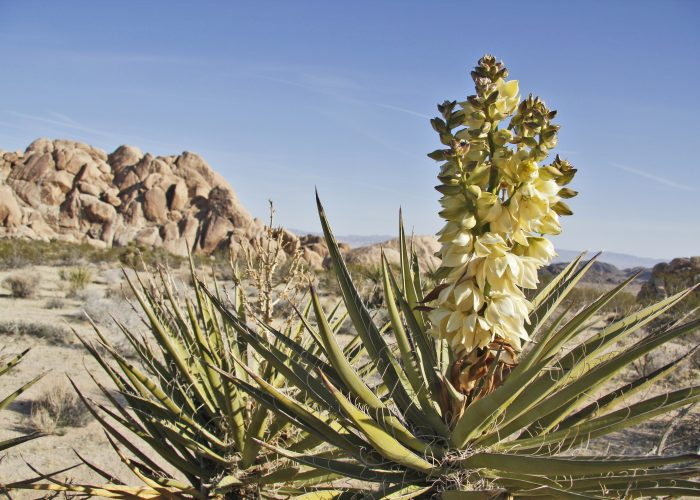

In [33]:
## all default values, should produce many random suggestions
generate_flower_suggestion()

how about a nice quesnelia?



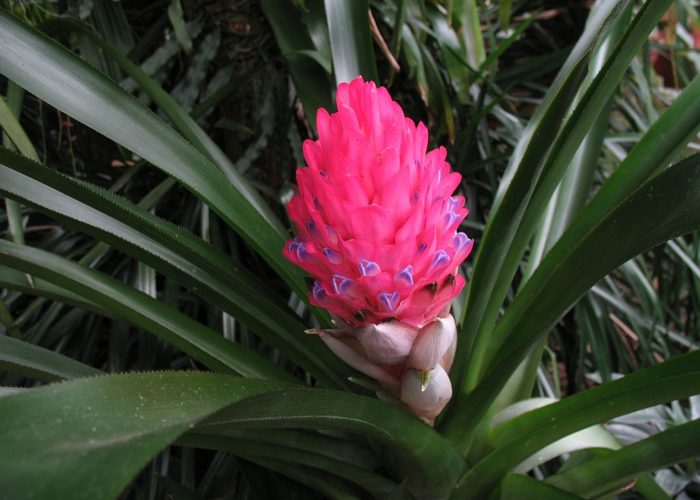

In [34]:
## all defaults except zone, should start seeing repeats quickly as not many flowers in zone 12
generate_flower_suggestion(zone=[12])

how about a nice lavandula?



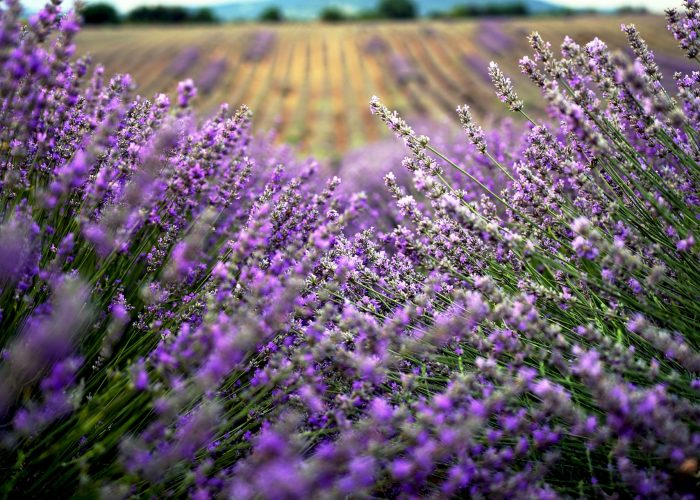

In [35]:
## only one flower, the lavandula, meets this criteria. should return this flower every time
generate_flower_suggestion(zone = [7],sun=['full sun'],
                           bloom_season=['summer','spring'],low_water = 'Y', expert='Y')

In [36]:
## no zone 2 winter flowers, no flowers in zone 1
generate_flower_suggestion(zone=[1,2],bloom_season=['winter'],sun=['shade'])

'sorry, no flowers to suggest'

how about a nice dryas?



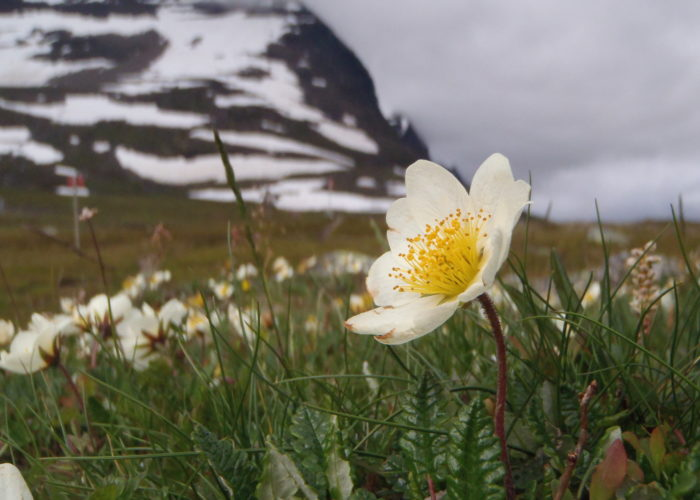

In [37]:
## what should I plant in zone 6 to grow this summer in partial sun? I have plenty of water and I'm not an expert
generate_flower_suggestion(zone=[6],sun=['partial sun'],bloom_season=['summer'])